# Descriptive summary of SNVs in WA-DoH and SCAN dataset

In this notebook, we use a Ct cutoff of 22 for SCAN samples and a Ct cutoff of 20 for WA-DoH samples and then characterize SNVs in samples at or below these Ct values. 

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#1082e6", "#8b2cde"])
from scipy import stats
from Bio import SeqIO

In [2]:
def load_metadata(file):
    '''
    Loads metadata tsv as df.
    '''
    with open(file) as tfile:
        metadata = pd.read_csv(tfile, sep = '\t')
        metadata['nwgc_id'] = metadata.nwgc_id.astype('str')
        metadata.loc[metadata.origin=='sfs', 'origin'] = 'scan'
    return metadata

def load_snvs(file):
    '''
    Loads SNVs dictionary
    '''
    with open(file) as jfile:
        snvs = json.load(jfile)
    return snvs

In [3]:
metadata = load_metadata('../results/metadata.tsv')
snvs = load_snvs('../results/snvs.json')

In [4]:
def create_snvs_df(metadata, snvs, origin1 = 'scan', ct1 = 22, origin2 = 'wadoh', ct2 = 20):
    '''
    Constructs df for analyses
    '''
    samples1 = metadata.loc[(metadata.origin == str(origin1)) & (metadata.avg_ct < ct1), 'nwgc_id']
    samples2 = metadata.loc[(metadata.origin == str(origin2)) & (metadata.avg_ct < ct2), 'nwgc_id']
    samples = samples1.append(samples2)
    positions = []
    variants = []
    frequencies = []
    ids = []
    for sample in samples:
        positions.extend(snvs[sample]['position'])
        variants.extend(snvs[sample]['variant'])
        frequencies.extend(snvs[sample]['frequency'])
        ids.extend([sample]*len(snvs[sample]['position']))
    df = pd.DataFrame()
    df['nwgc_id'] = ids
    df['position'] = positions
    df['variant'] = variants
    df['frequency'] = frequencies
    df = df.merge(metadata[['nwgc_id', 'origin']], how='left')
    return df

snvs_df = create_snvs_df(metadata, snvs)

## How many SNVs are there per sample?

In [5]:
def snvs_per_sample(df):
    samples = []
    snvs = []
    origins = []
    for sample in set(df['nwgc_id']):
        total_snvs = len(df.loc[df.nwgc_id == sample, 'nwgc_id'])
        samples.append(sample)
        snvs.append(total_snvs)
        origin = list(set(df.loc[df.nwgc_id == sample, 'origin']))
        origins.extend(origin)
    variants = pd.DataFrame()
    variants['nwgc_id'] = samples
    variants['iSNVs'] = snvs
    variants['origin'] = origins
    return variants

snvs_sample = snvs_per_sample(snvs_df)

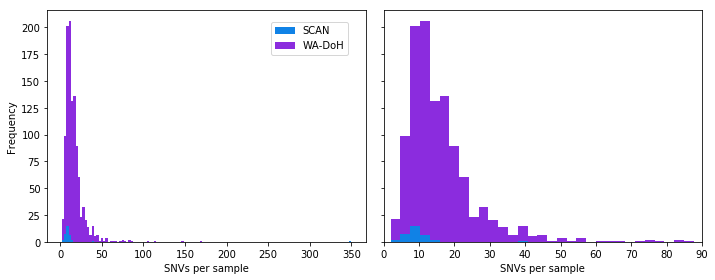

In [6]:
def plot_snvs_sample(df):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey=True)
    data = [df.loc[df.origin=='scan', 'iSNVs'], df.loc[df.origin=='wadoh', 'iSNVs']]
    labels=['SCAN', 'WA-DoH']
    ax2.set_xlim(left=0, right = 90)
    for ax in [ax1, ax2]:
        ax.set(xlabel='SNVs per sample')
        ax.hist(data, bins='fd', stacked=True)
    fig.legend(labels, loc = 'center', bbox_to_anchor=(0.43, 0.84))
    ax1.set_ylabel('Frequency')
    plt.tight_layout()
    return plt.show()

plot_snvs_sample(snvs_sample)
    

In [7]:
print('Mean for all: ' + str(np.mean(snvs_sample['iSNVs'])))
print('Median for all: ' + str(np.median(snvs_sample['iSNVs'])))

print('\nMean for SCAN: ' + str(np.mean(snvs_sample.loc[snvs_sample.origin=='scan', 'iSNVs'])))
print('Median for SCAN: ' + str(np.median(snvs_sample.loc[snvs_sample.origin=='scan', 'iSNVs'])))

print('\nMean for WA-DoH: ' + str(np.mean(snvs_sample.loc[snvs_sample.origin=='wadoh', 'iSNVs'])))
print('Median for WA-DoH: ' + str(np.median(snvs_sample.loc[snvs_sample.origin=='wadoh', 'iSNVs'])))

print(stats.mannwhitneyu(snvs_sample.loc[(snvs_sample.origin=='scan'), 'iSNVs'], snvs_sample.loc[snvs_sample.origin=='wadoh', 'iSNVs']))

Mean for all: 17.32387923147301
Median for all: 14.0

Mean for SCAN: 19.823529411764707
Median for SCAN: 10.0

Mean for WA-DoH: 17.243626062322946
Median for WA-DoH: 14.0
MannwhitneyuResult(statistic=9185.0, pvalue=5.509651136145631e-07)


## What is the distribution of SNVs' frequency?


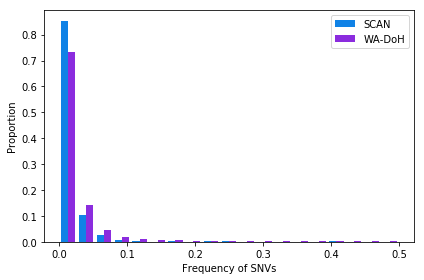

In [8]:
def plot_snvs_freq(df):
    fig, ax = plt.subplots()
    data = [df.loc[df.origin=='scan', 'frequency'], df.loc[df.origin=='wadoh', 'frequency']]
    labels=['SCAN', 'WA-DoH']
    ax.hist(data, label=labels,
            weights=[np.ones(len(data[0]))/ len(data[0]), np.ones(len(data[1]))/len(data[1])],
            #weights=[np.ones(len(data[0]))/ (len(data[0])+len(data[1])), np.ones(len(data[1]))/(len(data[0])+len(data[1]))], 
                     bins=19) #stacked=True)
    ax.legend()
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Frequency of SNVs')
    plt.tight_layout()
    return plt.show()

plot_snvs_freq(snvs_df)

SCAN has lower frequency SNVs and fewer SNVs than WA-DoH, but both sample have predominately low frequency SNVs.

## What types of mutations are the SNVs?

Coming soon!

## Where in the genome are SNVs located?

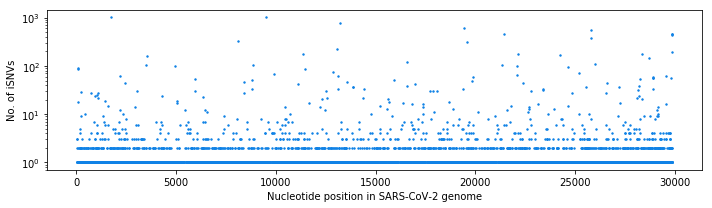

In [213]:
df_location = pd.value_counts(snvs_df.position).to_frame(name='count').rename_axis('position').reset_index()

def plot_snvs_genome(df):    
    fig, ax = plt.subplots(figsize=(10,3))
    ax.scatter(x=df['position'], y=df['count'], s=2)
    ax.set_yscale('log')
    ax.set_ylabel('No. of iSNVs')
    ax.set_xlabel('Nucleotide position in SARS-CoV-2 genome')
    plt.tight_layout()
    return plt.show()

plot_snvs_genome(df_location)

In [214]:
df_location.head(40)

,position,count
0,9502,1030
1,1730,1027
2,13225,768
3,19406,614
4,25777,565
5,29866,469
6,29867,453
7,21440,452
8,29865,432
9,25771,375


## Is their evidence of batch contamination?

In [89]:
def shared(metadata):
    df1 = metadata.loc[(metadata.origin == 'scan') & (metadata.avg_ct<22), ['nwgc_id', 'batch', 'strain', 'avg_ct']]
    df2 = metadata.loc[(metadata.origin == 'wadoh') & (metadata.avg_ct<20), ['nwgc_id', 'batch', 'strain', 'avg_ct']]
    df = df1.append(df2)
    df = df.sort_values(by=['batch', 'avg_ct']).reset_index()
    df = df[(df.nwgc_id!=386696) & (df.nwgc_id!=387185)]
    samples = df['nwgc_id'].astype('str')
    length = len(samples)
    adj_matrix = np.zeros((length, length))
    keys = ['position', 'variant']
    for indexA, sampleA in enumerate(samples):
        for indexB, sampleB in enumerate(samples):
            if indexA != indexB:
                A = {x:snvs[sampleA][x] for x in keys}
                B = {x:snvs[sampleB][x] for x in keys}
                dfA = pd.DataFrame.from_dict(data = A)
                dfB = pd.DataFrame.from_dict(data = B)
                if len(dfA.index) > 0:
                    if len(dfB.index) > 0:
                        df_merged = dfA.merge(dfB, how = 'inner', on =['position', 'variant'])
                        #shared = len(df_merged.index)
                        prop_shared = (len(df_merged.index)*2)/(len(dfA.index) + len(dfB.index))
                        adj_matrix[indexA, indexB] = prop_shared
                        adj_matrix[indexB, indexA] = prop_shared
    return df, adj_matrix
    
    

In [90]:
strains, matrix = shared(metadata)

In [192]:
batch, index = np.unique(strains['batch'], return_index=True)

In [210]:
matrix.shape

(1101, 1101)

In [211]:
index

array([  0,   1,   2,   4,   6,  17, 119, 151, 225, 411, 519, 535, 710,
       893])

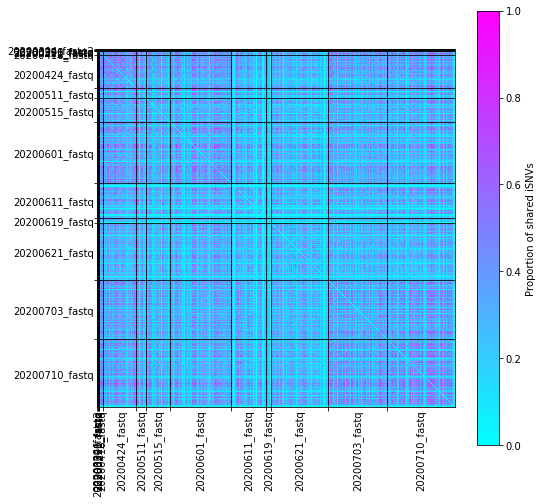

In [217]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(matrix, cmap = plt.get_cmap('cool'))
ax.tick_params(axis='both', length = 0, which='minor')
cbar = fig.colorbar(im) #extend='max')
cbar.set_label('Proportion of shared iSNVs')
ax.set_xticks(index - 0.5)
ax.set_yticks(index - 0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_yticks([0.5, 1.5, 3, 5, 11.5, 73, 135, 188, 318, 465, 527, 622.5, 801.5, 997], minor=True)
ax.set_xticks([0.5, 1.5, 3, 5, 11.5, 73, 135, 188, 318, 465, 527, 622.5, 801.5, 997], minor=True)
ax.set_xticklabels(batch, minor=True, rotation = 90)
ax.set_yticklabels(batch, minor=True)
ax.grid(color='black')
plt.show()



Some samples seem to share no SNVs at all, but many share some levels of SNVs. There does not appear to be any contamination by batch.